### Esercitazione FrameNet 

Consegna 2

Mario Scapellato

In [1]:
from nltk.corpus import framenet as fn
import csv
import hashlib
import random
from random import randint
from random import seed 
from nltk.corpus import wordnet as wn
import spacy

In [2]:
def print_frames_with_IDs():
    for x in fn.frames():
        print('{}\t{}'.format(x.ID, x.name))

def get_frames_ID():
    return [f.ID for f in fn.frames()]


def getFrameSetForStudent(surname, list_len = 5):
    id_framelist = []
    nof_frames = len(fn.frames())
    base_idx = (abs(int(hashlib.sha512(surname.encode('utf-8')).hexdigest(),16))% nof_frames)
    print('\nStudent: '+ surname)
    framente_IDs = get_frames_ID()
    i = 0
    offset = 0
    seed(1)

    while i < list_len: 
        fID = framente_IDs[(base_idx + offset)% nof_frames]
        f = fn.frame(fID)
        fNAME = f.name
        #Def = f.definition
        FEs = f.FE.keys()
        LUs=f.lexUnit.keys()
        print('\tID: {a:4d}\tframe: {framename}'.format(a = fID, framename = fNAME))
        #print()
        #print('\t Def : {Def}'.format(Def = Def))
        print()
        print('\tFes: {FE}\n LUs: {LU}'.format(FE=FEs, LU=LUs))
        id_framelist.append(fID)
        offset = randint(0, nof_frames)
        i += 1
    
    return id_framelist    

In [3]:
frame_ID = getFrameSetForStudent('scapellato')


Student: scapellato
	ID: 1625	frame: Agree_or_refuse_to_act

	Fes: dict_keys(['Speaker', 'Interlocutor', 'Medium', 'Proposed_action', 'Manner', 'Depictive', 'Means', 'Internal_cause', 'Place', 'Time', 'Purpose', 'Particular_iteration', 'Role', 'Co-timed_event', 'Frequency', 'Explanation', 'Event_description'])
 LUs: dict_keys(['refuse.v', 'decline.v', 'refusal.n', 'agree.v'])
	ID:  900	frame: Contingency

	Fes: dict_keys(['Outcome', 'Determinant', 'Degree', 'Circumstances'])
 LUs: dict_keys(['depend.v', 'function.n', 'dependent.a', 'depends.v', 'dependence.n', 'hang (on).v', 'turn.v', 'determine.v', 'independent.a', 'independence.n', 'hinge.v', 'factor.n', 'variable.n', 'dictate.v'])
	ID: 1840	frame: Vocalizations

	Fes: dict_keys(['Sound_source', 'Location_of_sound_source', 'Place', 'Internal_cause', 'Manner', 'Degree', 'Explanation', 'Path', 'Frequency'])
 LUs: dict_keys(['cry.n', 'howl.n', 'squeak.n'])
	ID: 1860	frame: Breaking_off

	Fes: dict_keys(['Subpart', 'Whole', 'Criterion',

In [4]:
#utilizzo spacy 
nlp = spacy.load("en_core_web_sm")

In [5]:
#funzione con cui recupero il frame a partire da suo ID
def get_frame_id(frame_id):
    f = fn.frame_by_id(frame_id)

    return f

#### Getting synset by a word

In [6]:
#estraggo il synset a partire da una parola
def get_synset(word):
    synset = wn.synsets(word)
    if synset == "":
        return "Null"
    else:
        return synset

##### importing spacy library for multiword. Posso cosi disambiguare le multiword

In [7]:
def get_reggex_expression(frame_name):

    if '-' or '_' in frame_name:
        
        main_word = ""
        
        # remove some punctualizations
        frame_name = frame_name.replace('_', ' ').replace('-', ' ')

        # Convert string into iterable obj with additional features (easy PoS tagging), using spacy
        frame_name = nlp(frame_name)
        #print("Frame:", frame_name)

        #Vedo se la parola è un NN o NNS oppure ROOT. Disambiguo il termine principale della parola. 
        #Nel mio caso per esempio ho "proposed_action" in cui la main word e' "action"
        for term in frame_name:
            # Main word is the NN or NNS in a sentence. 
            if term.tag_ == "NNS" or term.tag_ == "NN":
                main_word = term.text
            else:
                # Select the "root" term
                if term.dep_ == 'ROOT':
                    main_word = term.text
        #print("Main Word:", main_word)
        return main_word
    else:
        return frame_name


##### processing some strings, creating a list with name + definition

In [8]:
def processing(name, definition):
    res = []
    
    # string to delete
    str_delete = ["fe", "fn", "cod", "'", "$"]
    
    # set string to lowercase
    definition = definition.lower()
    
    # transform string into Doc with spacy
    definition = nlp(definition)

    # Now append the name
    res.append(name.lower())
    for term in definition:
        # Save only no stop and no punctalization term
        if not term.is_stop:
            if term.pos_ != "PUNCT" and term.pos_ != "NUM":
                res.append(term.lemma_)

    # In the end delete strings into other_str_delete variable
    res = list(filter(lambda x: x not in str_delete, res))

    return res

##### get frame name, frame element, lexical unit
##### Import la libreria re per caratteri speciali

In [9]:
import re

fe_list = []
fn_list = []
lu_list = []

for id in frame_ID:
    f = get_frame_id(id)
    fn_list.append(processing(get_reggex_expression(f.name), f.definition))

    for key in f.FE: 
        definition = f.FE[key].definition
        main_word = get_reggex_expression(key)
        fe_list.append(processing(main_word, definition))

    for key in f.lexUnit:
        lu_key = re.sub('\.[a-z]+', '', key)
        main_word = get_reggex_expression(lu_key)
        definition = f.lexUnit[key].definition
        lu_list.append(processing(main_word, definition))


Il contesto di disambiguazione dei termini w appartenenti a FN, è costruito utilizzando i termini (lemmatizzati e dopo filtraggio delle stopwords) presenti nelle descrizioni del frame e dei vari FEs

In [10]:
def get_examples(synset):
    examples = []
    if synset.examples():
        for example in synset.examples():
            examples.append(processing("", example))
    
    # Compose the result
    res = [item for sub_list in examples for item in sub_list]

    return res

##### check context  of a synset dependency by his hyponym ad hypernym

Per quanto riguarda il contesto dei sensi presenti in WN è possibile selezionare glosse ed  esempi dei sensi, e dei loro rispettivi iponimi e iperonimi, in modo da avere più  informazione, ottenendo quindi il contesto di disambiguazione  Ctx(s).

In [11]:
def get_context(synset):
    synset_def = []
    current_examples = []
    
    # take the synset definition and process it
    definition = synset.definition()
    synset_def = processing("", definition)

    # get examples of that synset
    current_examples = get_examples(synset)

    #check hyponyms
    hyponyms = synset.hyponyms()
    hypon_list = []
    hy_def = []
    
    if hyponyms !=0:
        
        limit = 0
        for hypon in hyponyms:
            if limit == 3:
                break
                
            # save hyponym definition and process it
            hy_def.append(processing("", hypon.definition()))
            
            # save hyponym examples
            hypon_list.append(get_examples(hypon))

            limit += 1
            
    #check hypernyms
    hypernyms = synset.hypernyms()
    hyper_list = []
    
    if hypernyms != 0:
        limit = 0
        for hyper in hypernyms:
            if limit == 3:
                break
                
            # save hypernym definition and process it
            hy_def.append(processing("", hyper.definition()))
            
            # save hypernym examples
            hyper_list.append(get_examples(hyper))
            
            limit += 1

    # Compose hypernym and hyponym definitions and examples
    hy_def = [item for sub_list in hy_def for item in sub_list]
    hyper_list = [item for sub_list in hyper_list for item in sub_list]
    hypon_list = [item for sub_list in hypon_list for item in sub_list]

    # Context composed by examples and definiton of current synset + hypernym and hyponym definitions + hypernym and hyponym definitions
    return current_examples + synset_def + hy_def + hypon_list + hyper_list

##### Now import my tsv files

In [12]:
def read_csv(path):
    
    with open(path, 'r', encoding='utf-8-sig') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t')
        res = []
        for row in csv_reader:
            res.append(row)
    return res


Per l'algoritmo di Mapping e' possibile usare il BOW: 
Approccio a bag of words, e scelta del senso che permette di massimizzare l'intersezione fra i contesti. 

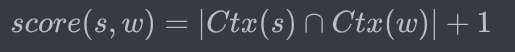

Viene restituito il senso che massimizza lo score(s,w).


In [13]:
def BOW(word, synsets):
  
    max_score = 0
    bag = list(word)
    best_synset = None
    
    if len(synsets) > 1:
        for synset in synsets:
            # Get context of the synset
            context = get_context(synset)
            context = list(context)
            
            # Calculate the intersection between word and context (+1 for Smoothing)
            score = len(set(word).intersection(context)) + 1
                        
            # Save the synset with higher score
            if score > max_score:
                max_score = score
                best_synset = synset
    else:
        best_synset = synsets
    

    return best_synset


In [14]:
fe = 'utils/fe_resource.tsv'
fn = 'utils/fn_resource.tsv'
lu = 'utils/lu_resource.tsv'

fn_import = read_csv(fn)
fe_import = read_csv(fe)
lu_import = read_csv(lu)

bow = []

#compute fe, fn, lu
for i in range(0, len(fn_import)):
    synsets = wn.synsets(fn_import[i][0])
    best_synset = BOW(fn_list[i], synsets)
    bow.append(best_synset)

for i in range(0, len(fe_import)):
    synsets = wn.synsets(fe_import[i][0])
    best_synset = BOW(fe_list[i], synsets)
    bow.append(best_synset)

for i in range(0, len(lu_import)):
    synsets = wn.synsets(lu_import[i][0])
    best_synset = BOW(lu_list[i], synsets)
    bow.append(best_synset)


##### Accuracy score

In [18]:
total = fn_import + fe_import + lu_import
right = 0

for i in range(0, len(bow)):
    current_mapping = str(bow[i]).replace('[', '').replace(']', '').replace("Synset('", '').replace("')", '')
    
    # Comparison between computed senses and hand written senses
    if current_mapping == total[i][1]:
        right += 1
      
print("Right mappings: ", right, "\nWrong mappings: ", len(bow)-right)
print("Accuracy: ", round(right/len(bow), 2))

#print(bow)

Right mappings:  43 
Wrong mappings:  31
Accuracy:  0.58


Alcuni termini sono diversi: come per esempio io ho annatato place.n.02 mentre come output il risultato restituito e' stead.n.01. Il significato non e' troppo troppo diverso. Stesso discorso per iteration dove ho scritto iteration.n.03 e come output e' stato restituito iteration.n.01, ma significano pressoche la stessa cosa. Questo puo essere dovuto dal fatto che quando disambiguo il contesto, oltre a prendere definizione e gloss di esempi per ciascun frame, ho aggiunto anche iperonimi e iponimi per dare maggiore informazione al contesto di disambiguazione.